In [363]:
## IMPORT ##

import sys
import glob
import os
import json
from os import listdir
from os.path import isfile, join

from collections import defaultdict,Counter
import math

import pandas as pd
#import plotly as py
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# vcf parser and associated utilities
# VariantFile is the the pysam vcf file handler returning a pysam vcf record
from pysam import VariantFile
from pybedtools import BedTool, create_interval_from_list

#Fot the http request to jvenn
from IPython.display import display, HTML
#py.offline.init_notebook_mode(connected=True)



In [364]:
## FUNCTIONS ##
def loadSVfromDetectionDirectories(sv_type, directory, extension='vcf.gz', size_min=0, size_max=0, verbose=False):
    records = defaultdict()
    headers = []
    for sv in sv_type:
        records[sv]=[]

    #print(sv_type, directories, extension, size_min, size_max)
    for sv in sv_type:
        sv_dir = directory + "/" + sv + "/"            
        try:
            variant_files = [f for f in listdir(sv_dir) if isfile(join(sv_dir, f))]
        except FileNotFoundError:
            print("Directory not Found : ",join(sv_dir))
            continue
            
        for file in variant_files:
            if file.endswith(extension):
                try:
                    sv_in = VariantFile(join(sv_dir,file))
                    headers.append(sv_in.header)
                except ValueError:
                    print("Incorrect format for file : ",join(sv_dir,file))

                for r in sv_in:
                    sv_size = r.stop - r.start + 1
                    if (size_min == 0 and size_max == 0) or (sv_size>=size_min and sv_size<=size_max):
                        records[sv].append(r)
    if verbose:                    
        print("SV_TYPE : ",sv_type)
        print("Number of variant for each SV_TYPE : ")
        for sv in sv_type:
            print("   ",sv,len(records[sv]))
                        
    return records,headers

def getDetectedRecordsId(record,sv_type,tools):
    detected_all = defaultdict(list)
    #Initialisation
    for sv in sv_type:
        detected_all[sv]=defaultdict(list)
        for t in tools:
            detected_all[sv][t]=[]
            
    for sv in sv_type:
        for t in tools:
            for r in record[sv][t]:
                detected_all[sv][t].append(r.id)
    return detected_all


def formatDetectedVariant(record,sv_type,tools,verbose=True):
    detected_all = defaultdict(list)
    #Initialisation
    for sv in sv_type:
        detected_all[sv]=defaultdict(list)
        for t in tools:
            detected_all[sv][t]=[]
    
    for sv in sv_type:
        for r in record[sv]:
            tool_name = r.id.split('_')[0]
            if tool_name not in tools:
                print('Unsupported tool results',tool_name)
                continue
            else:
                detected_all[sv][tool_name].append(r)
                
            if (len(r.filter)==0) or ((len(r.filter) == 1) and ('PASS' in r.filter)):
                detected_all[sv]['PASS'].append(r)
                

    if verbose:
        print("Tools results detected : ",tools)    
        print("Number of variant DETECTED for each SV_TYPE : ")
        for t in tools:
            print("   ",t,":")
            for sv in sv_type:
                print("       ",sv,":",len(detected_all[sv][t]))
    return detected_all

def initFormattedRecord(sv_type,tools):
    record = defaultdict(list)
    for sv in sv_type:
        record[sv]=defaultdict(list)
        for t in tools:
            record[sv][t]=[]
    return record

def getFormattedRecordBySize(record,sv_type,tools,min_size,max_size):
    size_record = initFormattedRecord(sv_type,tools)
    for sv in sv_type:
        for t in tools:
            for r in record[sv][t]:
                if min_size <= abs(r.stop-r.start)+1 < max_size:
                    size_record[sv][t].append(r)
    return size_record
    
    

def getNumbersFromFormattedRecord(record,sv_type,tools,min_size=0, max_size=0):
    
    number_record = initFormattedRecord(sv_type,tools)
    
    for sv in sv_type:
        for t in tools:
            number_record[sv][t]=defaultdict(list)
            number_record[sv][t]['PASS']=0
            number_record[sv][t]['DUPLICATE']=0
            number_record[sv][t]['FILTEREDOUT']=0
            
    if (max_size > 0) and (min_size < max_size):
        record = getFormattedRecordBySize(record,sv_type,tools,min_size,max_size)
        
    for sv in sv_type:
        for t in tools:
            if t == 'PASS':
                number_record[sv][t]['PASS'] = len(record[sv][t])
                number_record[sv][t]['DUPLICATE'] = 0
                number_record[sv][t]['FILTEREDOUT'] = 0
            else:
                for r in record[sv][t]:
                    if (len(r.filter)==0) or ((len(r.filter) == 1) and ('PASS' in r.filter)):
                        number_record[sv][t]['PASS']+=1
                    elif len(r.filter)==1 and 'DUPLICATE' in r.filter:
                        number_record[sv][t]['DUPLICATE'] +=1
                    else:
                        number_record[sv][t]['FILTEREDOUT'] +=1
    
    return number_record
    
def getDataFrame(record,sv_type,tools):
    data=[]
    for sv in sv_type:
        data_tool=[]
        for t in tools:
            data_tool.append(len(record[sv][t]))
        data.append(data_tool)
    return data

In [365]:
## VARIABLES ##
sv_type=['INV','DEL','DUP']
#species=['bee','chicken','goat','poplar','human','zea']
tools=['PASS','pindel','delly','lumpy','genomestrip']
#detection_dir="../batch001/filtered/"
detection_dir="./"
tools_color=['#3498db','#e74c3c','#1abc9c','#f39c12','#9b59b6']
#tools_color=['#3498db','#e74c3c','#1abc9c','#f39c12','#9b59b6']
#size_interval=[(0,200),(200,500),(500,1000),(1000,10000),(10000,50000),(50000,2000000)]
#size_interval_name=["0-200","200-500","500-1k","1k-10k","10k-50k","50k+"]

In [366]:
## Load SV ##
sv_records = defaultdict()
headers = []
sv_records,headers =loadSVfromDetectionDirectories(sv_type,detection_dir)
formatted_records = formatDetectedVariant(sv_records,sv_type,tools,verbose=False)

               
## SV stat by tool ##
#table



In [5]:
#print(headers[0])
#for ctg in headers[0].contigs:
#    print(ctg)

In [367]:
def table2htmlstr(data,table_title,column_header,row_header):
    html_table_str=""
    table_style = "style=\"font-size: 16px;border:none\""
    column_header_style = "style=\"background-color:midnightblue; color:white; font-size: 20px;\""
    row_header_style = "style=\"text-align:center;font-size: 20px;\""
    
    cell_width = str(int(100/(len(column_header)+1)))+"%"

    html_table_str = "<font size=5>"+table_title+"</font>"
    html_table_str += "<table "+table_style+">"
    html_table_str += "<tr "+column_header_style+"><td width="+cell_width+"></td>"
    for t in tools:
        html_table_str += "<td width="+cell_width+">"+t+"</td>"
    html_table_str += "</tr>"

    for sv in sv_type:
        html_table_str +="<tr><td "+row_header_style+">"+sv+"</td>"
        for t in tools:
            html_table_str += "<td>"+str(data[sv][t])+"</td>"
        html_table_str +="</tr>"
    html_table_str +='</table>'
    
    return html_table_str


tools=['pindel','delly','lumpy','genomestrip','combined']
numbers = defaultdict()
for sv in sv_type:
    if sv not in numbers:
        numbers[sv] = defaultdict()
    numbers[sv]['combined']=0
    for t in tools:
        if t != 'combined':
            numbers[sv][t] = len(formatted_records[sv][t])
            for r in formatted_records[sv][t]:
                if "DUPLICATE" not in r.filter:
                    numbers[sv]['combined']+=1
#print(numbers)
html_table_str = table2htmlstr(numbers,"Number of raw SV found by tool",tools,sv)
display(HTML(html_table_str))


In [368]:
### SVLEN   
def find_tool_duplicate_id(sv,t,records):
    tool_pass=[r for r in records[sv]['PASS'] if r.id.split("_")[0] == t]
    tool_pass_pybed = vcf_to_pybed(tool_pass)
    tool_pybed = vcf_to_pybed(records[sv][t])
    duplicate_id= [row[7] for row in tool_pass_pybed.intersect(tool_pybed, f=0.9, r=True, wo=True) if row[3]!=row[7] ]
    return duplicate_id


duplicate_id = defaultdict()
for sv in sv_type:
    duplicate_id[sv]=defaultdict(list)
    for t in tools:
        duplicate_id[sv][t]=find_tool_duplicate_id(sv,t,formatted_records)


In [369]:
numbers = defaultdict()
for sv in sv_type:
    if sv not in numbers:
        numbers[sv] = defaultdict()
    for t in tools:
        numbers[sv][t]=len([r for r in formatted_records[sv][t] if (len(r.filter)==0) or (len(r.filter)==1 and 'PASS' in r.filter) or (len(r.filter)==1 and 'DUPLICATE' in r.filter) and (r.id not in duplicate_id[sv][t])])
    
html_table_str = table2htmlstr(numbers,"Number of filtered SV found by tool",tools,sv)
display(HTML(html_table_str)) 

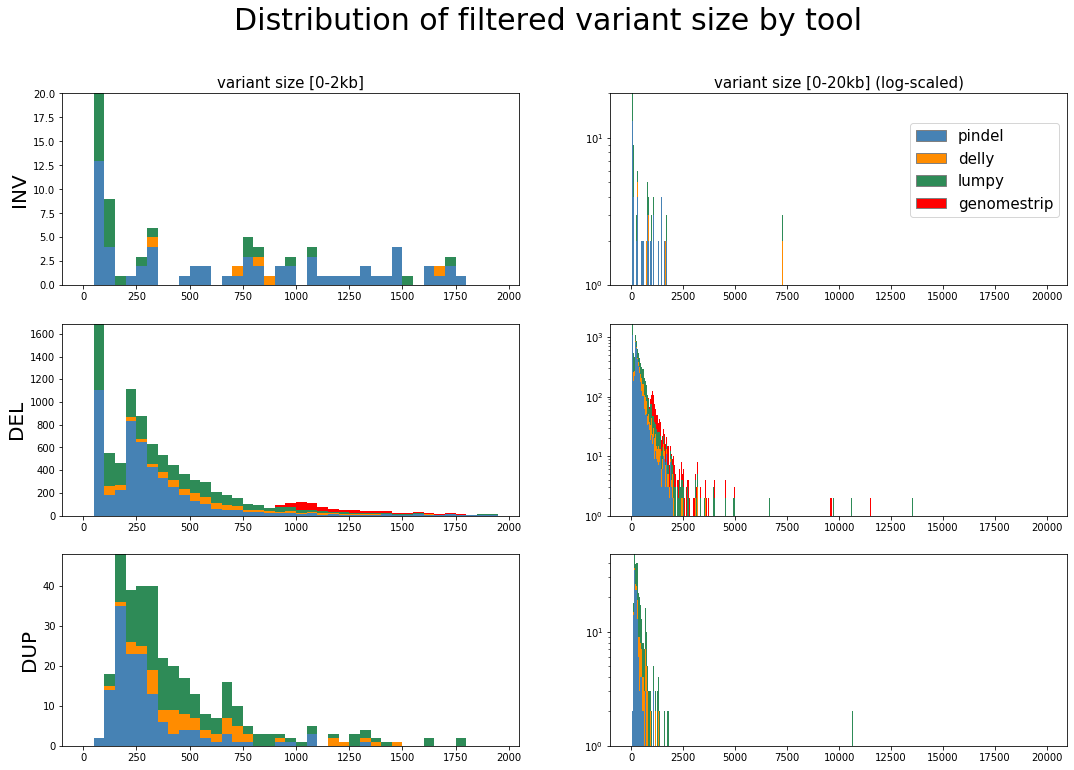

In [370]:
svlen_tools = ['pindel', 'delly', 'lumpy','genomestrip']
svlen_tools_color=colors=['steelblue','darkorange','seagreen','red']

#print(duplicate_id['INV']['pindel'])

#for t in svlen_tools:

dict_lengths = defaultdict()
for sv in sv_type:
    dict_lengths[sv]=defaultdict(list)
    for t in tools:
        dict_lengths[sv][t] = [r.rlen for r in formatted_records[sv][t] if (len(r.filter)==0) or (len(r.filter)==1 and 'PASS' in r.filter) or (len(r.filter)==1 and 'DUPLICATE' in r.filter) and (r.id not in duplicate_id[sv][t])]

        

f,axarr = plt.subplots(3,2,sharex=False,sharey=False,figsize=(18,12))
index=-1
for sv in sv_type:
    index+=1
    lengths = []
    for t in svlen_tools:
        lengths.append(dict_lengths[sv][t])
    axarr[index][0].hist(x=lengths, bins=[i for i in range(0, 2000, 50)],stacked=True, histtype='bar', label=svlen_tools, color=svlen_tools_color)
    axarr[index][1].hist(x=lengths, bins=[i for i in range(0, 20000, 50)],stacked=True, histtype='bar', label=svlen_tools, color=svlen_tools_color, log=True)
    axarr[index][0].set_ylabel(sv,fontsize=20)

axarr[0][0].set_title("variant size [0-2kb]",fontsize=15)
axarr[0][1].set_title("variant size [0-20kb] (log-scaled)",fontsize=15)

a_val = 1
legend=[]
for i in range(0,len(svlen_tools)):
    legend.append(mpatches.Patch( edgecolor='grey', facecolor=svlen_tools_color[i],alpha=a_val,label=svlen_tools[i]))
plt.legend(handles = legend,loc="right",fontsize=15, bbox_to_anchor=(1,3))
#l2 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Filtered out')
#l3 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Filtered out')
#l4 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Filtered out')
#plt.legend(handles = [l1,l2],loc="right",fontsize=20, bbox_to_anchor=(1.5,0.5))

f.suptitle("Distribution of filtered variant size by tool",fontsize=30)
plt.show()



In [371]:
def vcf_to_pybed(vcf_records):
    """
    Convert vcf records to bed records
    :param vcf_records: the vcf records
    :type vcfrecords: a list of vcf records
    :return: the corresponding betools records
    :rtype: a bedtools object
    """
    intervals = []
    for record in vcf_records:
        chrom = record.chrom
        start = record.start # pysam start is 0-based inclusive just like bed
        end = record.stop  # pysam stop is 0-based exclusive just like bed
        name = record.id
        interval_list = list(map(str, [chrom, start, end, name]))
        #print(interval_list)
        intervals.append(create_interval_from_list(interval_list))
    #print(intervals)
    #return BedTool(intervals).sort()
    return BedTool(intervals)

def getIntersectPassTool(r_pass,r_tool,tool):
    pass_pybed = vcf_to_pybed(r_pass)
    tool_pybed = vcf_to_pybed(r_tool)
    return set([row[3] for row in pass_pybed.intersect(tool_pybed, f=0.9, r=True, wo=True)])

#detection_dir="data/sheep_raw/filtered/"
#sv_records = defaultdict()
#headers = []
#sv_records,headers =loadSVfromDetectionDirectories(sv_type,detection_dir)
#formatted_records = formatDetectedVariant(sv_records,sv_type,tools,verbose=False)

found = defaultdict()

for sv in sv_type:
    found[sv]=defaultdict()
    for t in ['pindel','delly','lumpy','genomestrip']:
        found[sv][t] = getIntersectPassTool(formatted_records[sv]['PASS'],formatted_records[sv][t],t)



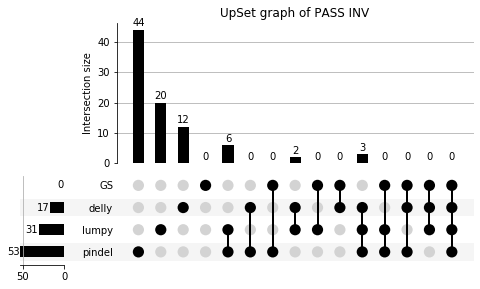

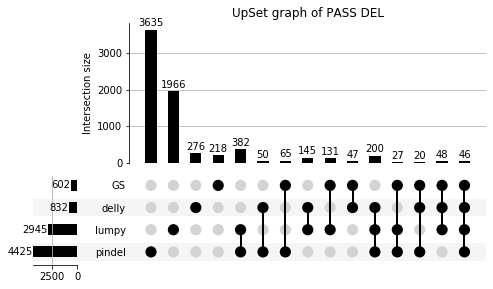

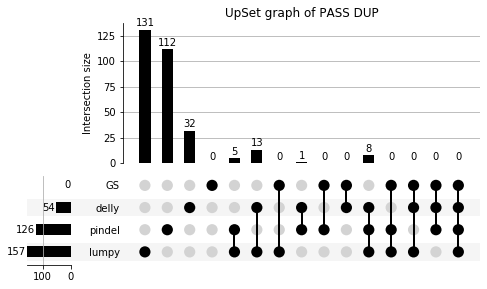

In [372]:
from upsetplot import plot
from upsetplot import from_memberships

for sv in sv_type:
    f = plt.figure(figsize=(20, 10))
    found_pindel = found[sv]['pindel']
    found_delly = found[sv]['delly']
    found_lumpy = found[sv]['lumpy']
    found_genomestrip = found[sv]['genomestrip']

    found_pindel_only = found_pindel - (found_delly  | found_lumpy | found_genomestrip)
    found_remains = found_pindel - found_pindel_only

    found_pindel_delly_only = (found_remains & found_delly) - (found_lumpy | found_genomestrip)
    found_pindel_lumpy_only = (found_remains & found_lumpy) - (found_delly | found_genomestrip)
    found_pindel_genomestrip_only = (found_remains & found_genomestrip) - (found_lumpy | found_delly)
    found_remains = found_remains - found_pindel_delly_only - found_pindel_lumpy_only - found_pindel_genomestrip_only

    found_pindel_delly_lumpy_only = (found_remains & found_delly & found_lumpy) - found_genomestrip
    found_pindel_delly_genomestrip_only = (found_remains & found_delly & found_genomestrip) - found_lumpy
    found_pindel_lumpy_genomestrip_only = (found_remains & found_lumpy & found_genomestrip) - found_delly
    found_remains = found_remains - found_pindel_delly_lumpy_only - found_pindel_delly_genomestrip_only - found_pindel_lumpy_genomestrip_only

    found_all = found_pindel & found_delly  & found_lumpy & found_genomestrip
    found_remains = found_remains - found_all


    found_delly_only = found_delly - (found_pindel  | found_lumpy | found_genomestrip)
    found_remains = found_delly - found_delly_only - found_pindel
    found_nopindel_delly_lumpy_only = (found_remains & found_lumpy) - found_genomestrip
    found_nopindel_delly_genomestrip_only = (found_remains & found_genomestrip) - found_lumpy
    found_remains = found_remains - found_nopindel_delly_lumpy_only - found_nopindel_delly_genomestrip_only
    found_nopindel_delly_lumpy_genomestrip = found_remains


    found_lumpy_only = found_lumpy - (found_pindel  | found_delly | found_genomestrip)
    found_remains = found_lumpy - found_lumpy_only - found_pindel - found_delly
    found_nopindel_nodelly_lumpy_genomestrip = found_remains & found_genomestrip
    found_genomestrip_only = found_genomestrip - (found_pindel  | found_lumpy | found_delly)


    example = from_memberships(
    [
        ['pindel'],
        ['pindel','delly'],
        ['pindel','lumpy'],
        ['pindel','GS'],
        ['pindel','delly','lumpy'],
        ['pindel','delly','GS'],
        ['pindel','lumpy','GS'],
        ['pindel','delly','lumpy','GS'],
        ['delly'],
        ['delly','lumpy'],
        ['delly','GS'],
        ['delly','lumpy','GS'],
        ['lumpy'],
        ['lumpy','GS'],
        ['GS']
    ],data=[len(found_pindel_only), len(found_pindel_delly_only), len(found_pindel_lumpy_only),len(found_pindel_genomestrip_only),len(found_pindel_delly_lumpy_only),len(found_pindel_delly_genomestrip_only),len(found_pindel_lumpy_genomestrip_only)
            ,len(found_all),len(found_delly_only),len(found_nopindel_delly_lumpy_only),len(found_nopindel_delly_genomestrip_only),len(found_nopindel_delly_lumpy_genomestrip)
           ,len(found_lumpy_only),len(found_nopindel_nodelly_lumpy_genomestrip),len(found_genomestrip_only)]
    )



    plot(example,fig = f, show_counts='%d')
    f.figsize=(20,10)
    plt.title("UpSet graph of PASS "+sv )
    plt.show()

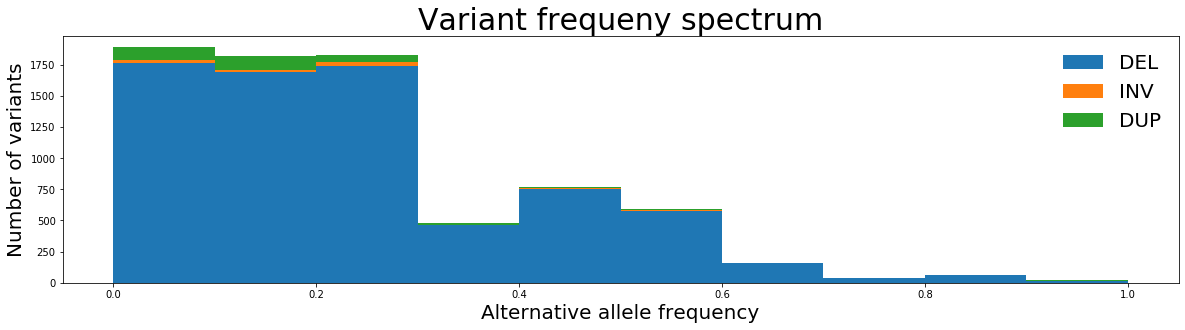

In [373]:
### Nouveau graph donné par Thomas : frequency spectrum
def var_frequency(rec):
    alt_alleles = 0
    informative_samples = 0 
    for s in rec.samples:
        geno = rec.samples[s]['GT']
        if not valid_geno:
            continue
        informative_samples += 1
        if geno == (0,1):
            alt_alleles += 1
        elif geno == (1,1):
            alt_alleles += 1 ### =>2
    if informative_samples == 0: ### 2* ( on passe en nb de copie)
        return None
    else:
        return float(alt_alleles)/informative_samples 



def valid_geno(geno):
    if geno == (0,0) or geno == (0,1) or geno == (1,1):
        return True
    else:
        return False

frequencies = []
dict_of_frequencies=defaultdict(list)
standard_svtype = ['DEL', 'INV', 'DUP']

for sv in standard_svtype:
    dict_of_frequencies[sv] = []
    for r in formatted_records[sv]['PASS']:
        freq = var_frequency(r)
        if freq is not None:
            dict_of_frequencies[sv].append(freq)

fig = plt.figure(figsize=(20, 10)) 
#fig.suptitle("Variant frequeny spectrum", fontsize=14)
standard_order = ['DEL', 'INV', 'DUP']
names, frequencies = zip(
        *sorted([(svtype, frequencies) for svtype, frequencies in dict_of_frequencies.items()],
                key=lambda x: standard_order.index(x[0])))
plt.subplot(2, 1, 1)
plt.hist(x=frequencies,
         bins=10,
         range=(0,1),
         stacked=True,
         histtype='bar',
         label=names)
plt.xlabel('Alternative allele frequency',fontsize=20)
plt.ylabel('Number of variants',fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.title("Variant frequeny spectrum", fontsize=30)
plt.show()

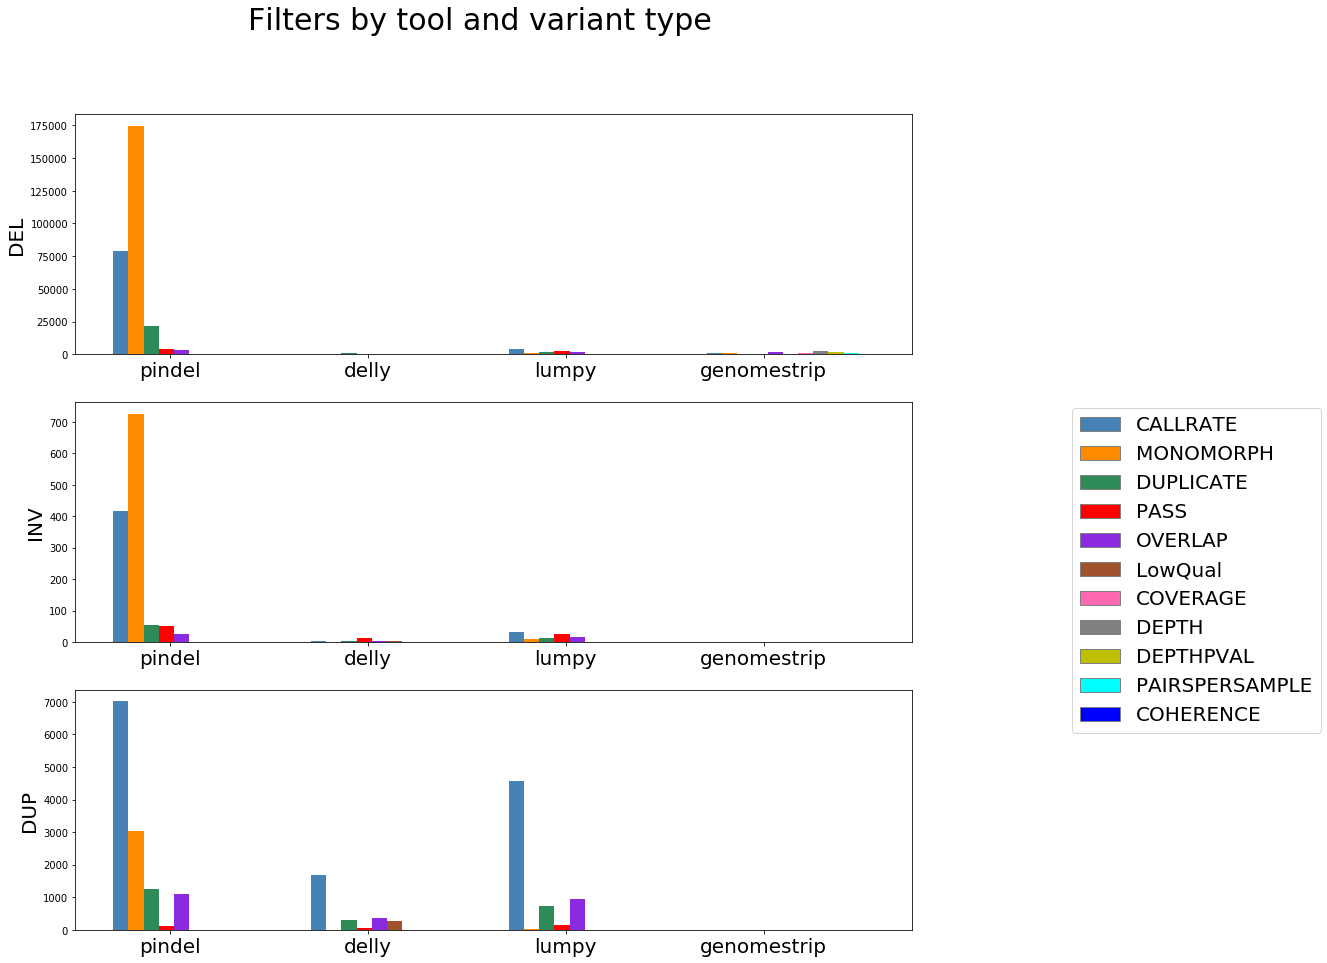

In [374]:
sv_type = ['DEL', 'INV', 'DUP']
tools = ['pindel','delly','lumpy','genomestrip']
colors=['steelblue','darkorange','seagreen','red','blueviolet','sienna','hotpink','grey','y','cyan','b','lightcoral','yellow','deeppink','tan']

def filter_summary(variants):
    counter = defaultdict()
    filters = []
    for sv in sv_type:
        counter[sv] = defaultdict(Counter)
        for t in tools :
            for v in variants[sv][t]:
                for f in v.filter:
                    counter[sv][t][f]+=1
                    if f not in filters:
                        filters.append(f)
    return counter,filters

counter,filters = filter_summary(formatted_records)

fig,axarr = plt.subplots(3,1,sharex=False,sharey=False,figsize=(15,15))

barWidth = 1 / (len(filters) + 2)

for sv_index in range(0,len(sv_type)):
    bars = []
    sv = sv_type[sv_index]
    for f in filters:
        bar_filter=[]
        for t in tools:
            bar_filter.append(counter[sv][t][f])
        bars.append(bar_filter)

    for f_index in range(0,len(filters)):
        r = [x + barWidth * f_index for x in range(0,len(tools))] 
        data = bars[f_index]
        axarr[sv_index].bar(r,data,label=filters[f_index], width=barWidth, color = colors[f_index])
        axarr[sv_index].set_ylabel(sv,fontsize=20)
        
#plt.xticks([r + ((len(filters) +2) / 4)*barWidth for r in range(0,len(tools))], tools)
a_val = 1
patches=[]
for f_index in range(0,len(filters)):
    patches.append(mpatches.Patch( edgecolor='grey', facecolor=colors[f_index],alpha=a_val,label=filters[f_index]))
    
fig.suptitle("Filters by tool and variant type",fontsize=30)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks([r + ((len(filters) +2) / 4)*barWidth for r in range(0,len(tools))], tools, fontsize=20)

plt.legend(handles = patches,loc="right",fontsize=20, bbox_to_anchor=(1.5,1.5))
plt.show()





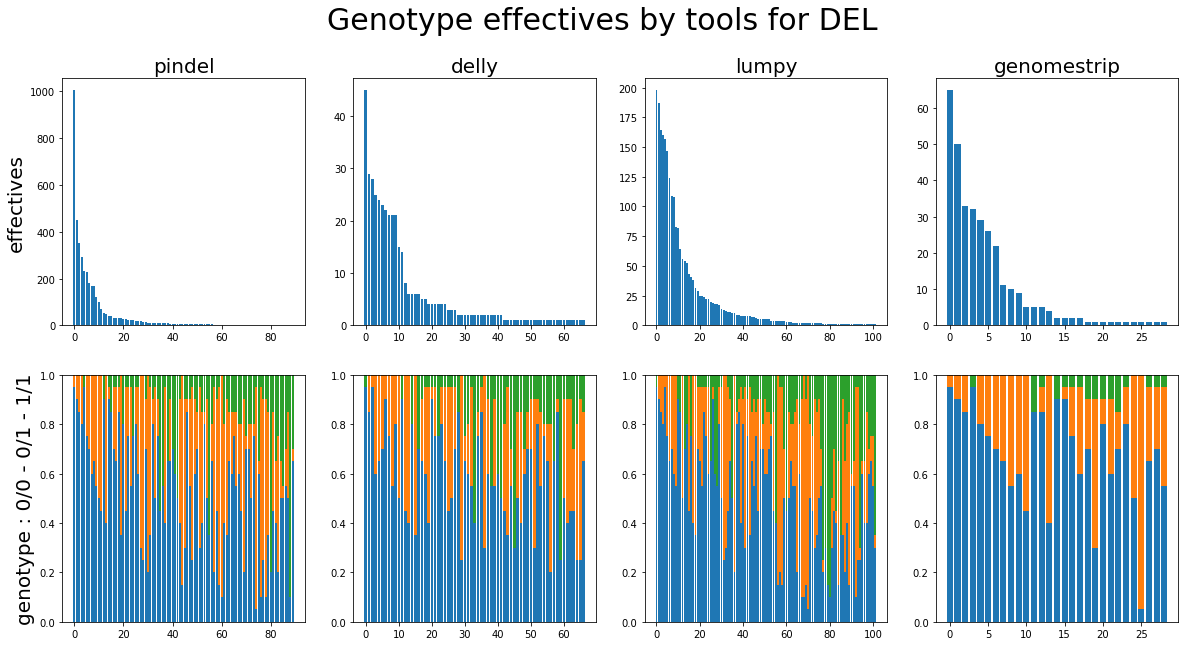

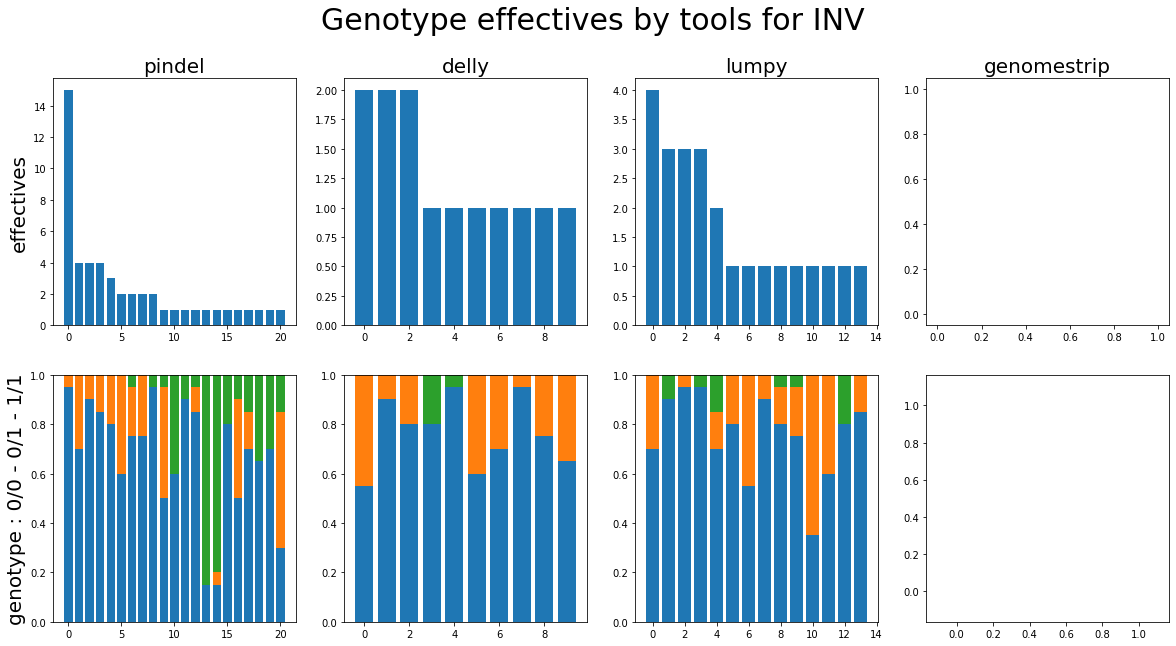

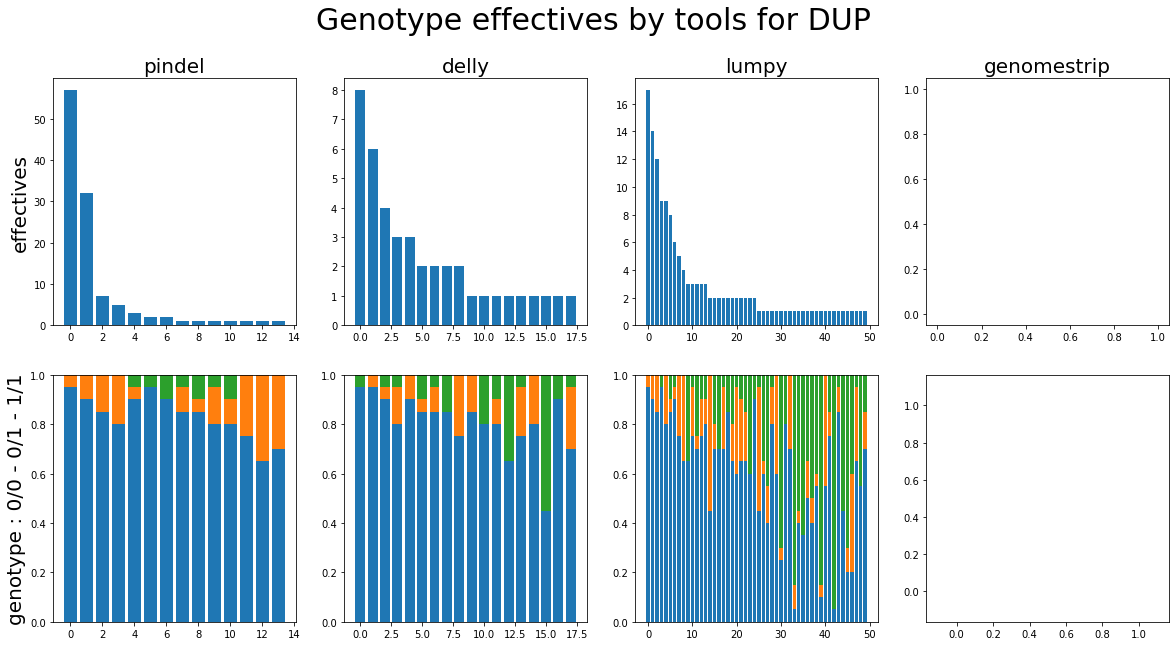

In [375]:
### Nouveau graph donné par Thomas : frequency spectrum
def concatGenotype(geno_s):
    #return str(geno_s["0_0"])+"#"+str(geno_s["0_1"])+"#"+str(geno_s["1_1"])+"#"+str(geno_s["undef"])
    return str(geno_s["0_0"])+"#"+str(geno_s["0_1"])+"#"+str(geno_s["1_1"])

def genotype_summary(rec):
    g_sample = Counter()
    for s in rec.samples:
        geno = rec.samples[s]['GT']
        if not valid_geno:
            #g_sample["undef"]+=1
            continue
        else:
            if geno == (0,1):
                g_sample["0_1"]+=1
            elif geno == (1,1):
                g_sample["1_1"]+=1
            else:
                g_sample["0_0"]+=1
    return g_sample    

def valid_geno(geno):
    if geno == (0,0) or geno == (0,1) or geno == (1,1):
        return True
    else:
        return False

counter = defaultdict()
for sv in sv_type:
    counter[sv] = defaultdict(Counter)
    for t in tools:
        test = Counter()
        for r in formatted_records[sv][t]:
            if len(r.filter)==0 or (len(r.filter)==1 and 'PASS' in r.filter):
                counter[sv][t][concatGenotype(genotype_summary(r))]+=1
        #print(test)
        


for sv in sv_type:
    fig,axarr = plt.subplots(2,4,sharex=False,sharey=False,figsize=(20,10))
    for t_index in range(len(tools)):
        t = tools[t_index]
        r = [x for x in range(len(counter[sv][t]))]
        values=[int(y) for x,y in counter[sv][t].most_common()]
        axarr[0][t_index].bar(r,values)
        axarr[0][t_index].set_title(t,fontsize=20)

        values=[int(x.split("#")[0])/20 for x,y in counter[sv][t].most_common()]
        axarr[1][t_index].bar(r,values,label="0 / 0")

        bot = values
        values=[int(x.split("#")[1])/20 for x,y in counter[sv][t].most_common()]
        axarr[1][t_index].bar(r,values,bottom=bot,label="0 / 1")

        bot = [x+y for x, y in zip(bot,values)]
        values=[int(x.split("#")[2])/20 for x,y in counter[sv][t].most_common()]
        axarr[1][t_index].bar(r,values,bottom=bot,label="1 / 1")

    axarr[0][0].set_ylabel("effectives",fontsize=20)
    axarr[1][0].set_ylabel("genotype : 0/0 - 0/1 - 1/1",fontsize=20)
    fig.suptitle("Genotype effectives by tools for "+sv,fontsize=30)
    plt.show()


    

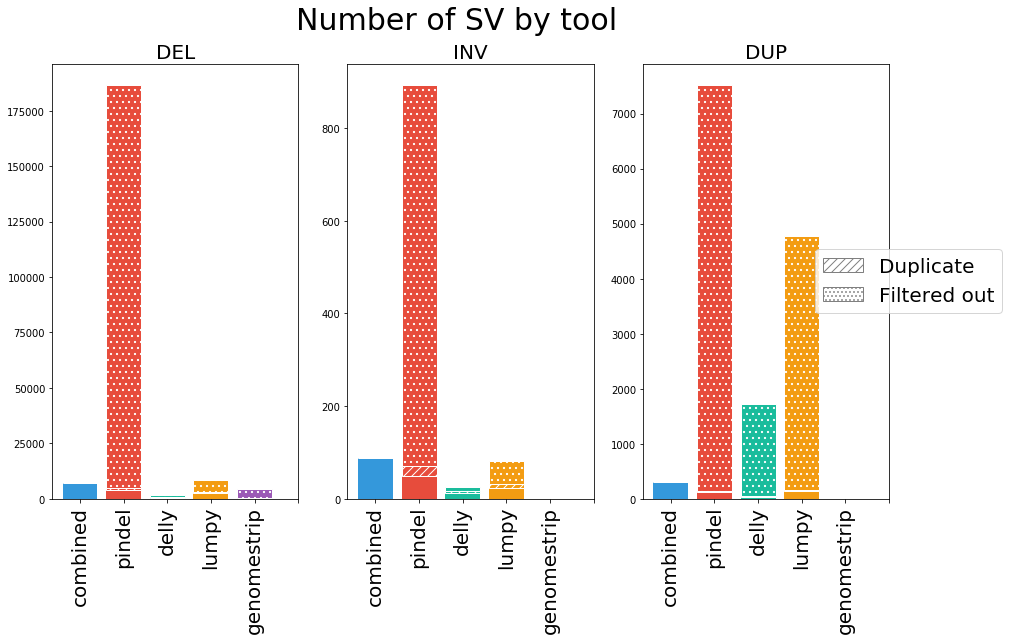

In [376]:
tools=['PASS','pindel','delly','lumpy','genomestrip']
tools_graph_names = ['combined','pindel','delly','lumpy','genomestrip']
## SV stat by tool ##
#graph
variant_number = getNumbersFromFormattedRecord(formatted_records,sv_type,tools)

variant_number[sv]['combined']
#print(variant_number)

f,axarr = plt.subplots(1,3,sharex=False,sharey=False,figsize=(15,8))
index=-1
for sv in sv_type:
    index += 1
    data_pass=[]
    data_duplicate=[]
    data_filteredout=[]
    for t in tools:
        data_pass.append(variant_number[sv][t]['PASS'])
        data_duplicate.append(variant_number[sv][t]['DUPLICATE']) 
        data_filteredout.append(variant_number[sv][t]['FILTEREDOUT'])
    
    axarr[index].bar(tools,data_pass,color=tools_color)
    axarr[index].bar(tools,data_duplicate,bottom = data_pass,color=tools_color,hatch='///',edgecolor='white')
    axarr[index].bar(tools,data_filteredout,bottom = [x+y for x, y in zip(data_pass,data_duplicate)],color=tools_color,hatch='..',edgecolor='white')
    axarr[index].set_title(sv,fontsize=20)
    
a_val = 1
l1 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Duplicate',hatch='r///')
l2 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Filtered out',hatch='r...')
plt.legend(handles = [l1,l2],loc="right",fontsize=20, bbox_to_anchor=(1.5,0.5))

f.suptitle("Number of SV by tool",fontsize=30)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(range(0,len(tools)+1),tools_graph_names,rotation=90,fontsize=20)

plt.show()